In [ ]:
# Carrie Lei & Diana Cantini
# Final Project: Phased Array Antenna Simulation

# Milestone 2 Goal: phase shifted input current sources; writing a better function to easily simulate multiple antennas in a row; NTFF transformations
# To be implemented next: 

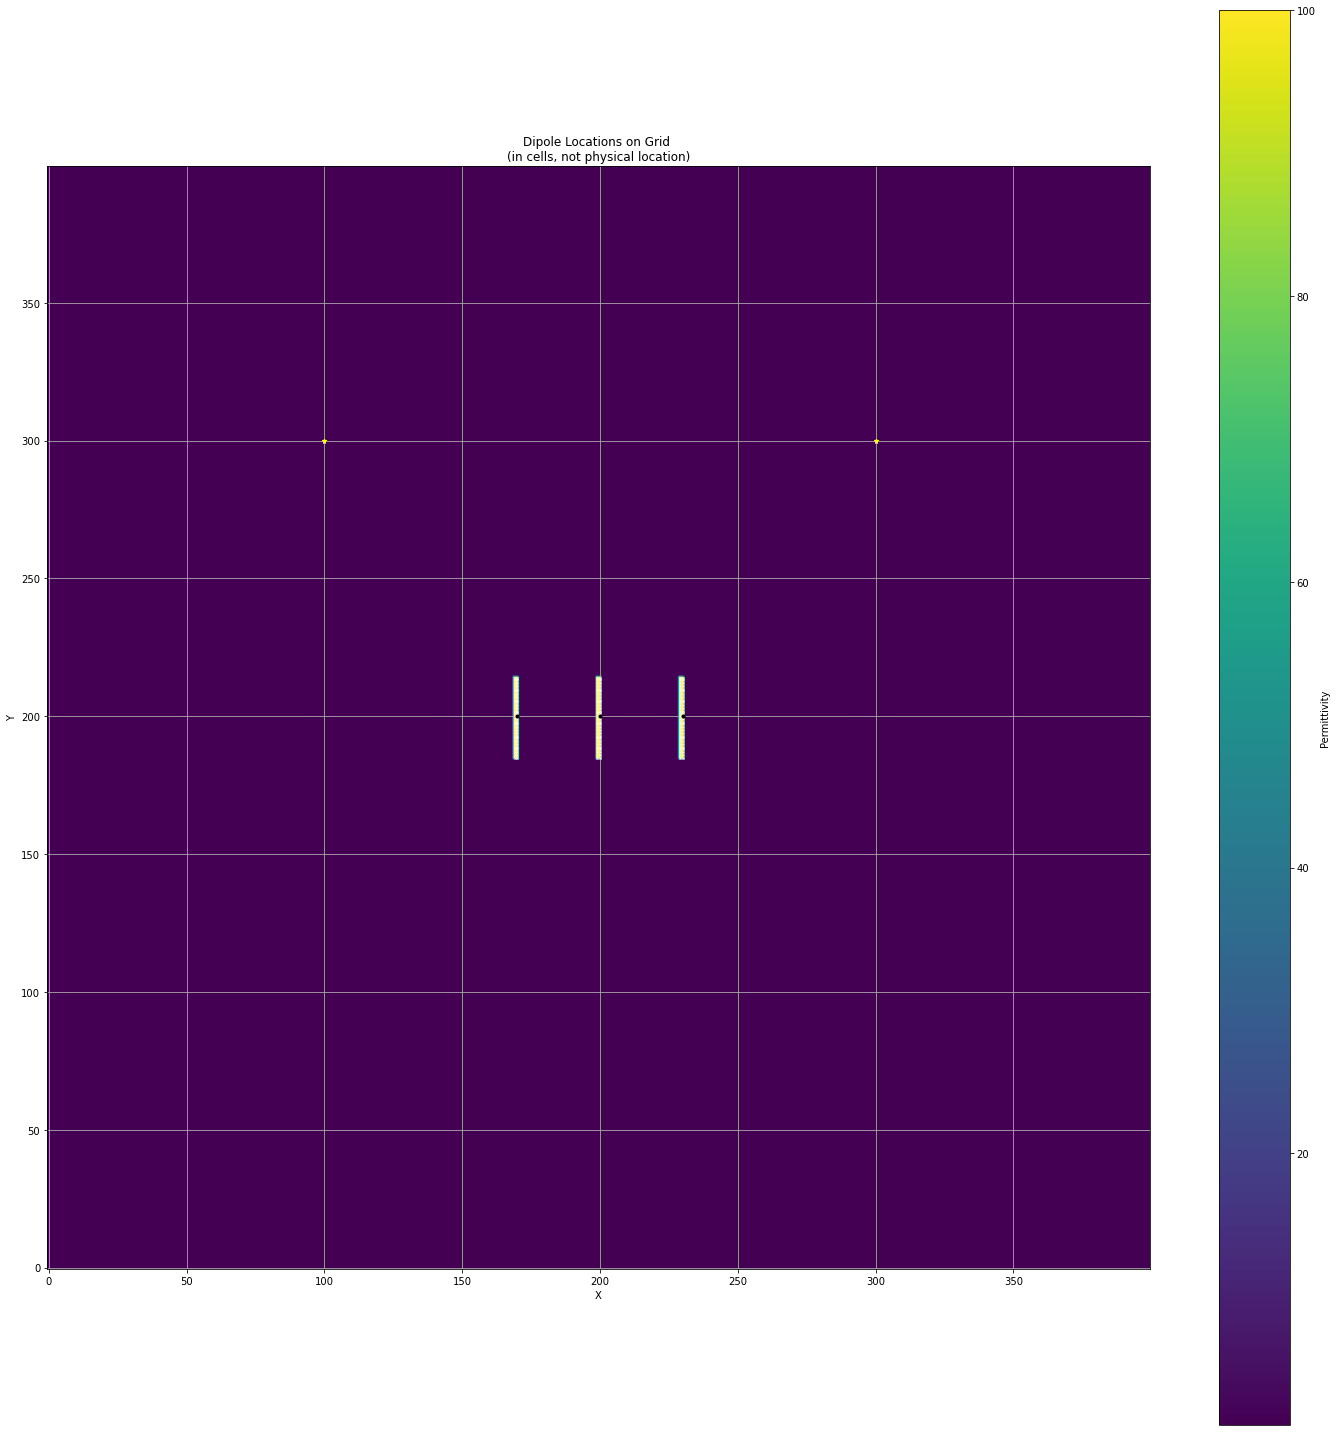

In [6]:
# streamlined function to simulate 1xn antennas

import matplotlib.pyplot as plt
import math
import numpy as np

# Simulation Parameters
e0 = 1        
mu0 = 1       
c0 = 1 / math.sqrt(e0 * mu0) 
dx = 0.5e-3 # unit cell is 0.5mm x 0.5mm
dy = 0.5e-3 
magic_time_step = dx / (np.sqrt(2) * c0)
max_time_steps = 500

# Grid in cell units
whole_grid = 200e-3 # whole grid = 200 mm
numX_cells = int(whole_grid / dx)  
numY_cells = int(whole_grid / dy)   
center_x = numX_cells // 2 # find center points
center_y = numY_cells // 2

# Set up the permittivity grid 
grid = np.ones((numY_cells, numX_cells)) * e0

# Source parameters
lambda0 = 6e-2 # wavelength for 5G is 6 cm
lambda_lower = 5e-2
lambda_upper = 7e-2
omega0 = (2 * np.pi * c0) / lambda0
sigma = (2 / omega0) * (lambda0 / (lambda_upper - lambda_lower))

# Arrays to store fields
Ez = np.zeros((numX_cells, numY_cells))
Hx = np.zeros((numX_cells, numY_cells))
Hy = np.zeros((numX_cells, numY_cells))

# Dipole Parameters
numberAntennas = 3
dipole_epsilon = 100
dipole_spacing_cells = int(15e-3 / dx) # space between dipoles = 15mm = 30 cells
dipole_width = 1e-3 # dipole thickness = 1 mm
dipole_height = 15e-3 # dipole height = 15 mm
dipole_width_cells = int(dipole_width / dx)         
dipole_height_cells = int(dipole_height / dy)  

# Probe locations
probe_beam_direction_x = int(numX_cells *.75) # this probe is put at the angle of target beam (45 degrees from x axis)
probe_beam_direction_y = int(numY_cells * .75)
probe_x = int(numX_cells * .25) # this probe is put far away from target angle (135 from x axis)
probe_y = int(numY_cells *.75)
Ez_probe_beam = np.zeros(max_time_steps) # store values at probes
Ez_probe = np.zeros(max_time_steps)


# Current source vectors
sources = []

def placeAndVisualizeAntennas(numAntennas, spacingBetween, dipoleLength, dipoleWidth, grid, e_dipole):

    # find where the centers of each dipole would be
    centers = []

    if (numAntennas %2) == 1: # for odd number of antennas, the middle one is at center of grid
        for i in range(numAntennas):
            leftPoint = center_x - (numAntennas //2) *spacingBetween
            centers.append(leftPoint + (i*spacingBetween))

    else: # for an even number of antennas, the middle point of grid is between two antennas
        spaceFromCenter = spacingBetween // 2
        for i in range(numAntennas):
            leftPoint = center_x - (numAntennas //2 -1) *spacingBetween - spaceFromCenter
            centers.append(leftPoint + (i*spacingBetween))

    # Visualize everything
    plt.figure(figsize=(20, 20))

    # Find dimensions of antenna on the grid
    for x in centers:
        x_center = x
        x_left = x_center - (dipoleWidth // 2)
        x_right = x_left + dipoleWidth - 1
        x_bottom = center_y - (dipoleLength // 2)
        x_top = x_bottom + dipoleLength - 1

        # place antennas on permittivity grid
        for y in range(x_left, x_right + 1):
            for z in range(x_bottom, x_top + 1):
                grid[z, y] = e_dipole
                plt.plot(y, z, 'x', markersize = 2, color='white')

        sources.append((x, center_y))
    
    # Show where the sources are injected on grid
    for location in sources:
        plt.plot(location[0], location[1], 'o', markersize = 3, color = 'black')
    
    # Show where the probes are on the grid
    plt.plot(probe_beam_direction_x, probe_beam_direction_y, '*', markersize = 5, color = 'yellow')
    plt.plot(probe_x, probe_y, '*', markersize = 5, color = 'yellow')
    
    # Plot the permittivity grid
    plt.imshow(grid, cmap='viridis', origin= 'lower')
    plt.colorbar(label='Permittivity')
    plt.title('Dipole Locations on Grid \n(in cells, not physical location)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    plt.grid()
    plt.show()

placeAndVisualizeAntennas(numberAntennas, dipole_spacing_cells, dipole_height_cells, dipole_width_cells, grid, dipole_epsilon)

In [7]:
# Beam steering using phase delays 

print(sources)

theta0 = 45 # target beam from z axis
phi0 = 45 # target beam from x axis

k = (np.pi * 2 / lambda0)
kx = k * np.sin(np.radians(theta0)) * np.cos(np.radians(phi0))
ky = k * np.sin(np.radians(theta0)) * np.sin(np.radians(phi0))

phasedSources = []

for location in sources:
    # convert location to physical location in mm (not num cells)
    phase = -(kx*location[0]*dx + ky*location[1]*dy) # in radians
    phasedSources.append((location[0], location[1], phase))

print(phasedSources) 

[(170, 200), (200, 200), (230, 200)]
[(170, 200, -9.68657734856853), (200, 200, -10.47197551196598), (230, 200, -11.257373675363429)]


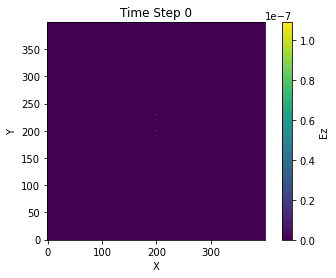

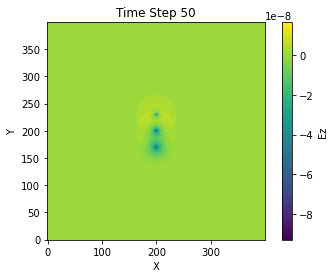

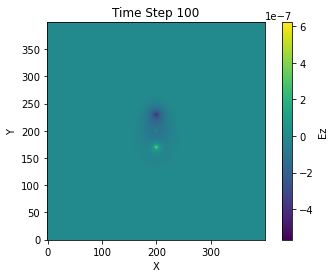

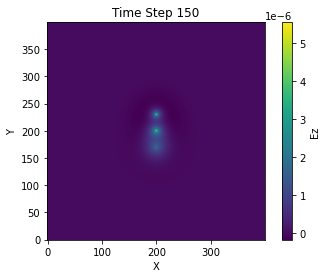

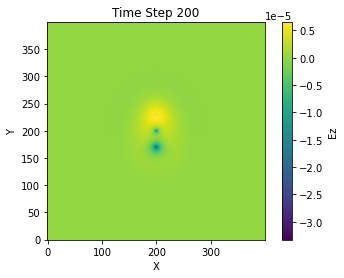

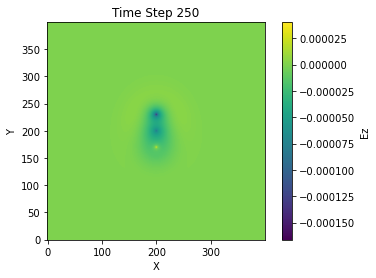

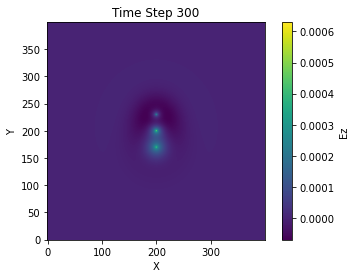

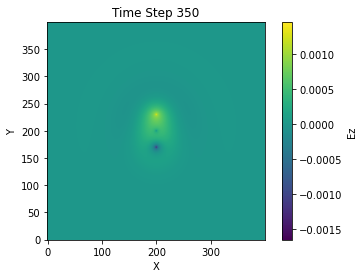

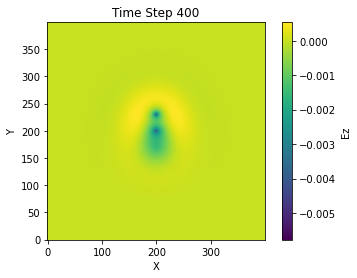

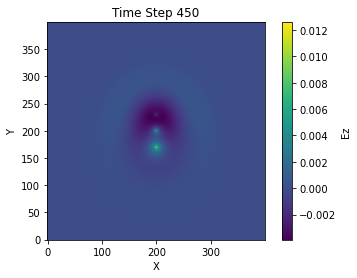

In [8]:
# 2D FDTD Model

# Using absorbing boundary condition to simulate the energy being absorbed in air.
boundaryLeft = np.zeros(numY_cells)
boundaryRight = np.zeros(numY_cells)
boundaryBottom = np.zeros(numX_cells)
boundaryTop = np.zeros(numX_cells)

# Main 2D FDTD Loop
for n in range(max_time_steps):

    # Compute Hy 
    for i in range(numX_cells - 1):
        for j in range(numY_cells):
            Hy[i, j] += (Ez[i + 1, j] - Ez[i, j]) * magic_time_step / dx

     # Compute Hx
    for i in range(numX_cells):
        for j in range(numY_cells - 1):
            Hx[i, j] -= (Ez[i, j + 1] - Ez[i, j]) * magic_time_step / dy


    # Use temp variables to store left and bottom Ez values sorta like a moving window; only 2 sides needed bc symmetrical
    tempLeft = Ez[1, :].copy() 
    tempBottom = Ez[:, 1].copy()  

    # Compute Ez
    for i in range(1, numX_cells - 1):
        for j in range(1, numY_cells - 1):
            Ez[i, j] += ((Hy[i, j] - Hy[i - 1, j]) * magic_time_step / dx) - ((Hx[i, j] - Hx[i, j - 1]) * magic_time_step / dy)
    
    # Store Ez at probes
    Ez_probe_beam[n] = np.abs(Ez[probe_beam_direction_x, probe_beam_direction_y])
    Ez_probe[n] = np.abs(Ez[probe_x, probe_y])

    # Apply excitation at antenna sources
    t_n = n * magic_time_step
    for (x_coord, y_coord, phase) in phasedSources:
        Ez[x_coord, y_coord] += np.exp(-((t_n - 4 * sigma) ** 2) / sigma ** 2) * np.sin(omega0 * t_n + phase)

    # Update absorbing conditions
    Ez[0, :] = boundaryLeft
    Ez[-1, :] = boundaryRight
    Ez[:, 0] = boundaryBottom
    Ez[:, -1] = boundaryTop

    # Update boundary buffers for next time step
    boundaryLeft = tempLeft
    boundaryBottom = tempBottom
    boundaryRight = Ez[-2, :].copy()
    boundaryTop   = Ez[:, -2].copy()
    
    # Visualize Ez field every 50 time steps
    if n % 50 == 0:
        plt.clf() 
        plt.imshow(Ez, cmap='viridis', origin='lower')
        plt.title(f"Time Step {n}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.colorbar(label="Ez")
        plt.pause(0.01) 

plt.show()

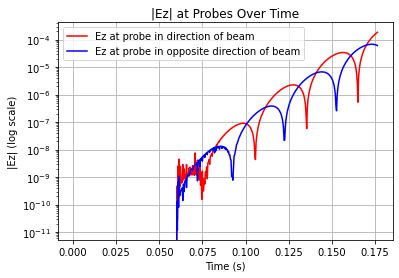

In [ ]:
# Plot Ez at the probe in direction of beam over time in comparison to probe at opposite direction; shows the 45 degrees out of phase with each other
time_steps = np.arange(max_time_steps)*magic_time_step
plt.semilogy(time_steps, Ez_probe_beam, label='Ez at probe in direction of beam', color = 'red')
plt.semilogy(time_steps, Ez_probe, label='Ez at probe in opposite direction of beam', color = 'blue')
plt.xlabel('Time (s)')
plt.ylabel('|Ez| (log scale)')
plt.title('|Ez| at Probes Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate gain difference between probes
power_off = np.sum(Ez_probe ** 2)
power_beam = np.sum(Ez_probe_beam ** 2)
gain_dB = 10 * np.log10(power_beam / power_off)
gain_dB # which means the probe at direction of beam had about 2.5 times increase in power

4.055075287264122